<a href="https://colab.research.google.com/github/ajay47847/pcg_classification/blob/main/FeatureExtratBox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


   Normal_Mean  Normal_Standard Deviation  Normal_Variance  Normal_Zero Crossing Rate  Normal_Root Mean Square  Normal_Kurtosis  Normal_Skewness  Normal_Form Factor  Normal_PSD Mean  Normal_PSD Standard Deviation  Abnormal_Mean  Abnormal_Standard Deviation  Abnormal_Variance  Abnormal_Zero Crossing Rate  Abnormal_Root Mean Square  Abnormal_Kurtosis  Abnormal_Skewness  Abnormal_Form Factor  Abnormal_PSD Mean  Abnormal_PSD Standard Deviation
0     0.806872                2032.986941     4.133036e+06                     0.5600              2032.987101        22.793595         0.393832         2519.590735      3538.365237                    6786.847148      -3.490373                  4409.457970       1.944332e+07                       0.1888                4409.459352           4.307733          -0.040770          -1263.320483       19049.269619                     48332.361048
1    -0.524690                2820.223012     7.953658e+06                     0.1796              2820.223061  

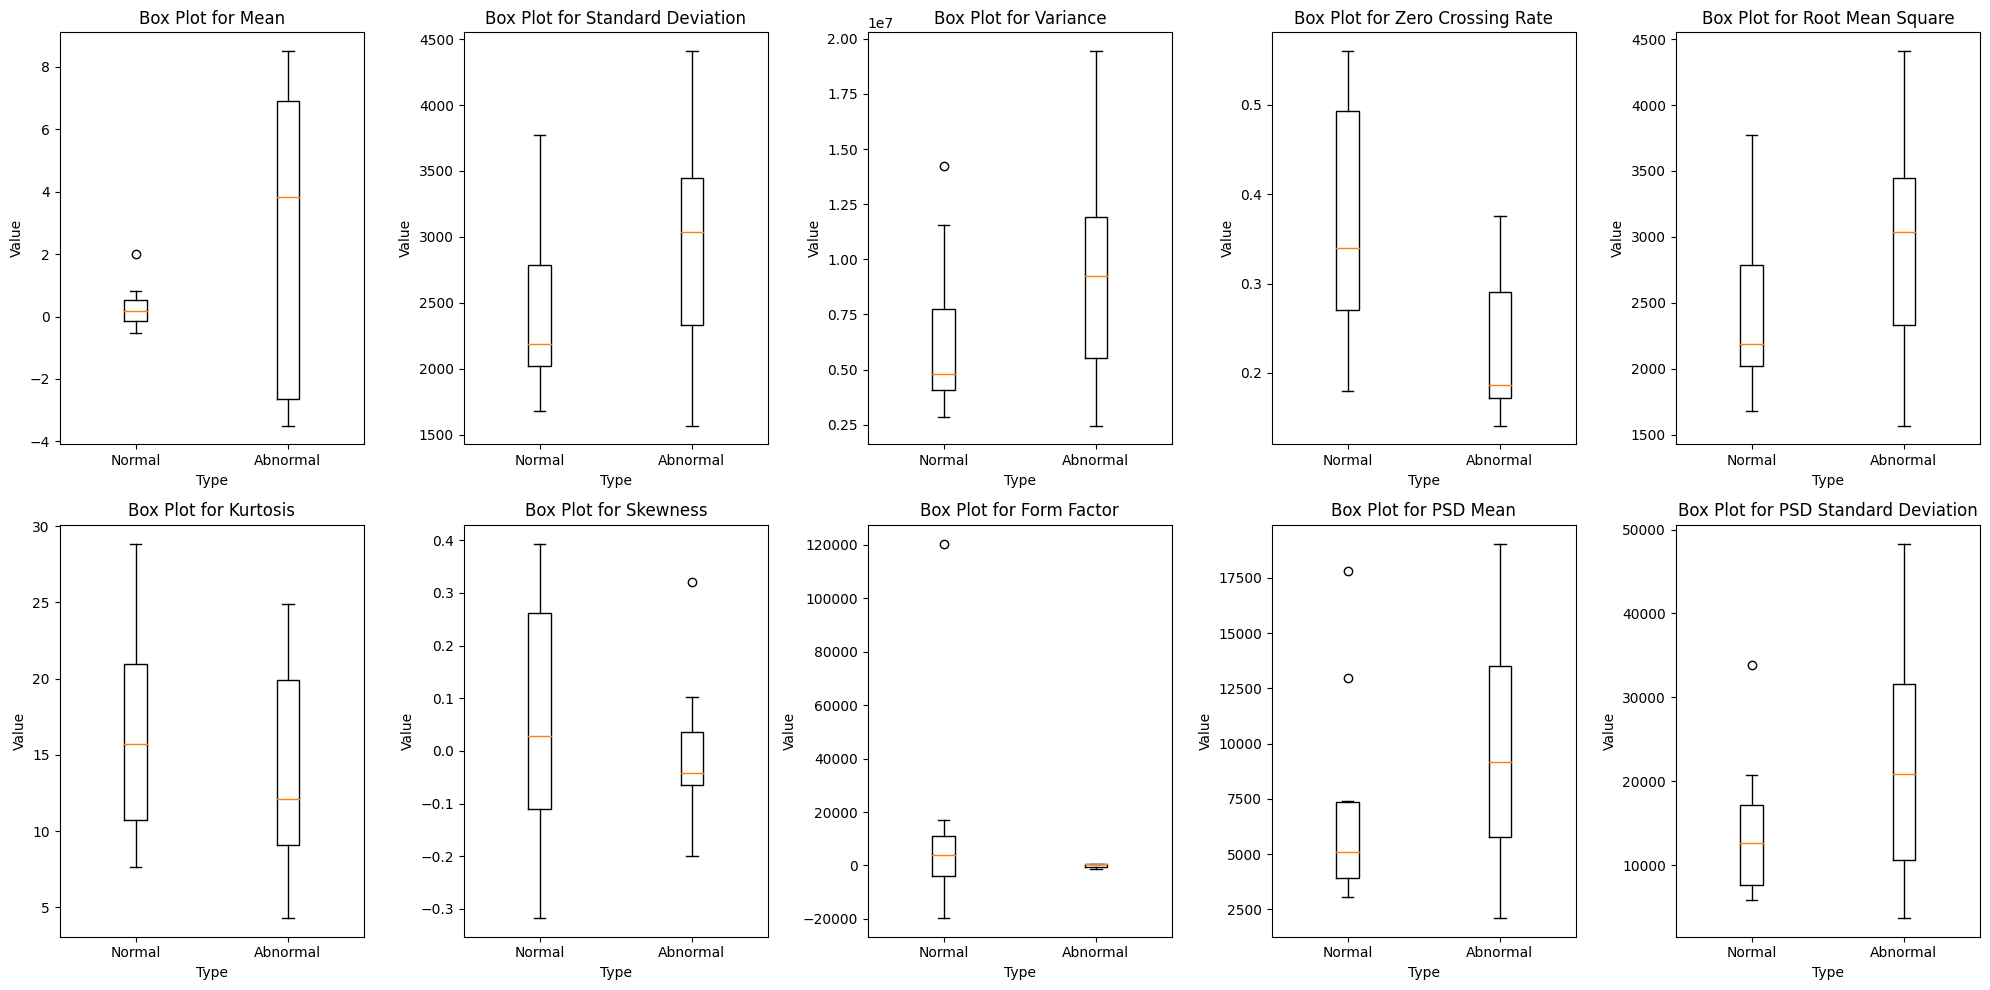

In [2]:
import pandas as pd
import numpy as np
import os
from scipy.io import wavfile
from scipy.signal import welch, butter, filtfilt
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt

def load_audio_files(file_list, folder_path):
    audio_data = []
    min_length = float('inf')
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        sr, y = wavfile.read(file_path)  # Load the audio file
        audio_data.append(y)
        min_length = min(min_length, len(y))
    # Trim all audio files to the minimum length
    audio_data = [audio[:min_length] for audio in audio_data]
    return np.array(audio_data), sr

def apply_filter(data, sample_rate, filter_type, cutoff_freqs):
    nyquist = 0.5 * sample_rate
    normalized_cutoff = [freq / nyquist for freq in cutoff_freqs]
    b, a = butter(N=1, Wn=normalized_cutoff, btype=filter_type)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def z_normalize_audio_data(audio_data):
    normalized_audio = []
    for signal in audio_data:
        mean_val = np.mean(signal)
        std_val = np.std(signal)
        if std_val == 0:
            normalized_signal = signal - mean_val
        else:
            normalized_signal = (signal - mean_val) / std_val
        normalized_audio.append(normalized_signal)
    return np.array(normalized_audio)

def feature_extraction(audio_data, sample_rate):
    feature_data = []
    for signal in audio_data:
        mean_value = np.mean(signal)
        std_value = np.std(signal)
        variance_value = np.var(signal)
        zero_crossing_rate_value = np.sum(np.abs(np.diff(np.sign(signal)))) / len(signal)
        rms_value = np.sqrt(np.mean(signal**2))
        kurtosis_value = kurtosis(signal)
        skewness_value = skew(signal)
        form_factor_value = rms_value / mean_value
        freq, psd = welch(signal, fs=sample_rate, nperseg=1024)
        psd_mean_value = np.mean(psd)
        psd_std_value = np.std(psd)
        feature_data.append([mean_value, std_value, variance_value, zero_crossing_rate_value,
                             rms_value, kurtosis_value, skewness_value, form_factor_value,
                             psd_mean_value, psd_std_value])
    return np.array(feature_data)

# Load the Excel file and select relevant columns
df = pd.read_excel('/content/PMEA_37_12_2181_OnlineAppendix.xlsx', sheet_name='SUAHSDB')
df = df[['Record name', 'Diagnosis', 'Type (-1=normal 1=abnormal)']]

# Extract 10 normal and 10 abnormal records
normal_records = df[df['Type (-1=normal 1=abnormal)'] == -1].head(10)
abnormal_records = df[df['Type (-1=normal 1=abnormal)'] == 1].head(10)

# Get the list of normal and abnormal record names
normal_record_names = normal_records['Record name'].tolist()
abnormal_record_names = abnormal_records['Record name'].tolist()

# Define the folder path containing the audio files
folder_path = '/content/drive/MyDrive/training-f'

# Get a list of all .wav files in the folder
audio_files = [file for file in os.listdir(folder_path) if file.endswith('.wav')]

# Filter the audio files based on normal and abnormal record names
normal_audio_files = [file for file in audio_files if any(record in file for record in normal_record_names)]
abnormal_audio_files = [file for file in audio_files if any(record in file for record in abnormal_record_names)]

# Load normal and abnormal audio data
normal_audio_data, sample_rate1 = load_audio_files(normal_audio_files, folder_path)
abnormal_audio_data, sample_rate2 = load_audio_files(abnormal_audio_files, folder_path)

# Extract 2.5 seconds of audio
duration = 2.5
num_samples1 = int(duration * sample_rate1)
num_samples2 = int(duration * sample_rate2)
normal_audio_data = normal_audio_data[:, :num_samples1]
abnormal_audio_data = abnormal_audio_data[:, :num_samples2]

# Apply bandpass filter
normal_audio_data_bandpass = apply_filter(normal_audio_data, sample_rate1, 'band', [25, 600])
abnormal_audio_data_bandpass = apply_filter(abnormal_audio_data, sample_rate2, 'band', [25, 600])

# Z-normalize the audio data
normal_audio_data_norm = z_normalize_audio_data(normal_audio_data_bandpass)
abnormal_audio_data_norm = z_normalize_audio_data(abnormal_audio_data_bandpass)

# Extract features
normal_features = feature_extraction(normal_audio_data_bandpass, sample_rate1)
abnormal_features = feature_extraction(abnormal_audio_data_bandpass, sample_rate2)

# Create DataFrame for normal features with prefixed column names
normal_columns = [f'Normal_{col}' for col in ['Mean', 'Standard Deviation', 'Variance', 'Zero Crossing Rate', 'Root Mean Square',
           'Kurtosis', 'Skewness', 'Form Factor', 'PSD Mean', 'PSD Standard Deviation']]
df_normal = pd.DataFrame(normal_features, columns=normal_columns)

# Create DataFrame for abnormal features with prefixed column names
abnormal_columns = [f'Abnormal_{col}' for col in ['Mean', 'Standard Deviation', 'Variance', 'Zero Crossing Rate', 'Root Mean Square',
           'Kurtosis', 'Skewness', 'Form Factor', 'PSD Mean', 'PSD Standard Deviation']]
df_abnormal = pd.DataFrame(abnormal_features, columns=abnormal_columns)

# Concatenate both DataFrames
df = pd.concat([df_normal, df_abnormal], axis=1)

# Print DataFrame
print(df.to_string())

# Define a function to create box plots for each feature
def create_box_plots(df, feature_names):
    plt.figure(figsize=(20, 10))
    for i in range(len(feature_names)):
        plt.subplot(2, 5, i + 1)
        feature = feature_names[i]
        plt.boxplot([df[f'Normal_{feature}'], df[f'Abnormal_{feature}']], labels=['Normal', 'Abnormal'])
        plt.title(f'Box Plot for {feature}')
        plt.xlabel('Type')
        plt.ylabel('Value')
    plt.tight_layout()
    plt.show()

# List of feature names
feature_names = ['Mean', 'Standard Deviation', 'Variance', 'Zero Crossing Rate', 'Root Mean Square',
                 'Kurtosis', 'Skewness', 'Form Factor', 'PSD Mean', 'PSD Standard Deviation']

# Create box plots for each feature
create_box_plots(df, feature_names)
